# Wavelet Graph Neural Network Robustness
 
Graph Wavelet Neural Networks (GWNNs) are a different flavor of Graph Convolutional Neural Networks (GCNNs) which incorporate the topology of the graph through an adaptation of the concept of wavelets on graph structure.
In this paper we explore how this new aggregation scheme impacts the robustness of the model on randomly altered graphs. We will focus on the effect of the scaling factor, characterising the nodes' neighbourhood. Finally, we will compare the results of this model with benchmark neural networks on several real-world datasets to quantify the effect of using wavelet-based layers in a Graph Neural Network.

# 0. Initialisation

## Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

## imports

In [ ]:
# We assume that PyTorch is already installed
import torch
torchversion = torch.__version__

# Install PyTorch Scatter, PyTorch Sparse, and PyTorch Geometric
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-{torchversion}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-{torchversion}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install pygsp
!pip install texttable
# Numpy for matrices
import numpy as np
np.random.seed(0)

# Visualization
import networkx as nx
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

import time
import torch
from tqdm import trange
from sklearn.model_selection import train_test_split
import json
import pygsp
import numpy as np
import pandas as pd
import networkx as nx
from scipy import sparse
from texttable import Texttable
from sklearn.preprocessing import normalize
import torch
from torch_sparse import spspmm, spmm
from torch_geometric.utils import to_networkx
from torch_geometric.utils import remove_isolated_nodes
import torch_geometric.datasets as datasets
import torch_geometric
import random

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Dataset

In [ ]:
# from torch_geometric.datasets import Planetoid

dataset = datasets.Planetoid(
    root="./",
    name='Citeseer', ### change for cora
    split="public",
    transform=torch_geometric.transforms.GCNNorm()
  )

data = dataset[0]

# Print information about the dataset
print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

# Print information about the graph
print(f'\nGraph:')
print('------')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Processing...
Done!


Dataset: Citeseer()
-------------------
Number of graphs: 1
Number of nodes: 3327
Number of features: 3703
Number of classes: 6

Graph:
------
Edges are directed: False
Graph has isolated nodes: True
Graph has loops: True


Remove Isolated Nodes

In [ ]:
isolated = (remove_isolated_nodes(data['edge_index'])[2] == False).sum(dim=0).item()
print(f'Number of isolated nodes = {isolated}')
G = to_networkx(data, to_undirected=True)
print(len(G.edges))

Number of isolated nodes = 48
7879


## Visuaize Dataset

In [ ]:
def display(G):
    plt.figure(figsize=(18,18))
    plt.axis('off')
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=False,
                    node_size=50,
                    node_color=data.y,
                    width=2,
                    edge_color="grey"
                    )
    plt.show()

## Visualize Node Degrees

<BarContainer object of 37 artists>

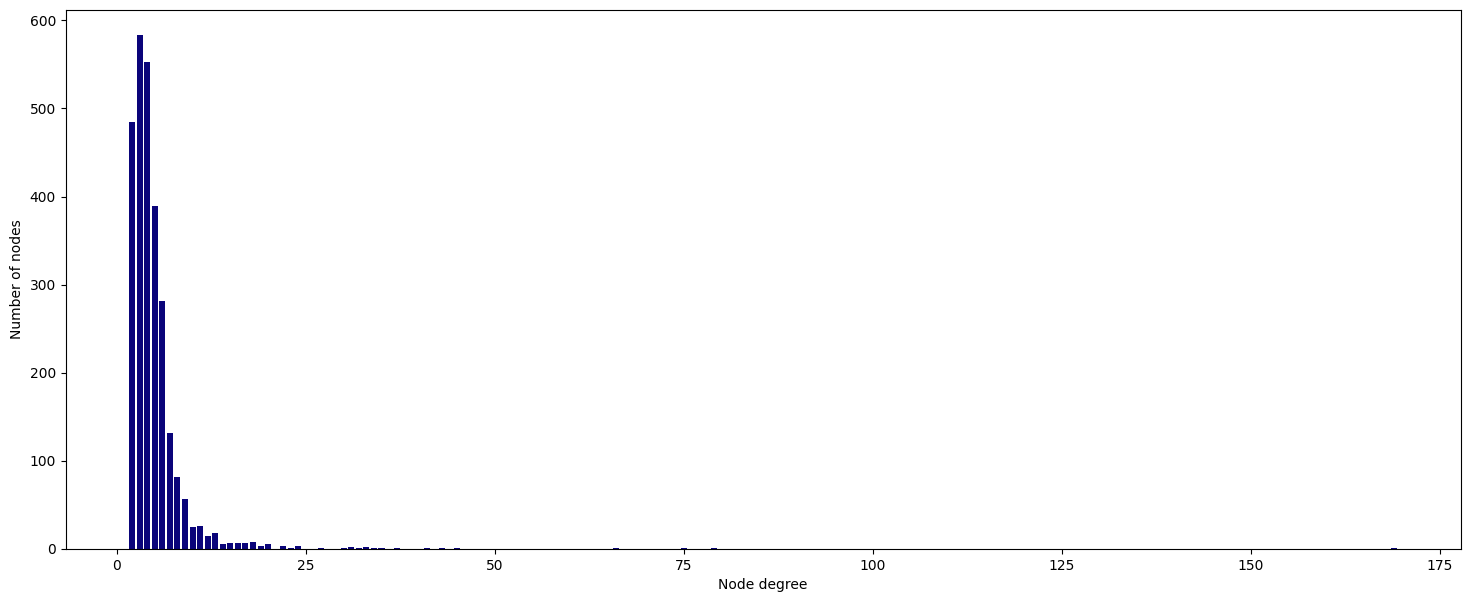

In [ ]:
from torch_geometric.utils import degree
from collections import Counter

# Get list of degrees for each node
degrees = degree(data.edge_index[0]).numpy()

# Count the number of nodes for each degree
numbers = Counter(degrees)

# Bar plot
fig, ax = plt.subplots(figsize=(18, 7))
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(),
        numbers.values(),
        color='#0A047A')

# 1. Utils

In [ ]:
def save_logs(args, logs):
    """
    Save the logs at the path.
    :param args: Arguments objects.
    :param logs: Log dictionary.
    """
    with open(args['log_path'], "w") as f:
        json.dump(logs, f)

class WaveletSparsifier(object):
    """
    Object to sparsify the wavelet coefficients for a graph.
    """
    def __init__(self, graph, scale, approximation_order, tolerance):
        """
        :param graph: NetworkX graph object.
        :param scale: Kernel scale length parameter.
        :param approximation_order: Chebyshev polynomial order.
        :param tolerance: Tolerance for sparsification.
        """
        self.graph = graph
        self.pygsp_graph = pygsp.graphs.Graph(nx.adjacency_matrix(self.graph))
        self.pygsp_graph.estimate_lmax()
        self.scales = [-scale, scale]
        self.approximation_order = approximation_order
        self.tolerance = tolerance
        self.phi_matrices = []

    def calculate_wavelet(self):
        """
        Creating sparse wavelets.
        :return remaining_waves: Sparse matrix of attenuated wavelets.
        """
        impulse = np.eye(self.graph.number_of_nodes(), dtype=int)
        wavelet_coefficients = pygsp.filters.approximations.cheby_op(self.pygsp_graph,
                                                                     self.chebyshev,
                                                                     impulse)
        wavelet_coefficients[wavelet_coefficients < self.tolerance] = 0
        ind_1, ind_2 = wavelet_coefficients.nonzero()
        n_count = self.graph.number_of_nodes()
        remaining_waves = sparse.csr_matrix((wavelet_coefficients[ind_1, ind_2], (ind_1, ind_2)),
                                            shape=(n_count, n_count),
                                            dtype=np.float32)
        return remaining_waves

    def normalize_matrices(self):
        """
        Normalizing the wavelet and inverse wavelet matrices.
        """
        print("\nNormalizing the sparsified wavelets.\n")
        for i, phi_matrix in enumerate(self.phi_matrices):
            self.phi_matrices[i] = normalize(self.phi_matrices[i], norm='l1', axis=1)

    def calculate_density(self):
        """
        Calculating the density of the sparsified wavelet matrices.
        """
        wavelet_density = len(self.phi_matrices[0].nonzero()[0])/(self.graph.number_of_nodes()**2)
        wavelet_density = str(round(100*wavelet_density, 2))
        inverse_wavelet_density = len(self.phi_matrices[1].nonzero()[0])/(self.graph.number_of_nodes()**2)
        inverse_wavelet_density = str(round(100*inverse_wavelet_density, 2))
        print("Density of wavelets: "+wavelet_density+"%.")
        print("Density of inverse wavelets: "+inverse_wavelet_density+"%.\n")

    def calculate_all_wavelets(self):
        """
        Graph wavelet coefficient calculation.
        """
        print("\nWavelet calculation and sparsification started.\n")
        for i, scale in enumerate(self.scales):
            self.heat_filter = pygsp.filters.Heat(self.pygsp_graph,
                                                  tau=[scale])
            self.chebyshev = pygsp.filters.approximations.compute_cheby_coeff(self.heat_filter,
                                                                              m=self.approximation_order)
            sparsified_wavelets = self.calculate_wavelet()          
            self.phi_matrices.append(sparsified_wavelets)
        self.normalize_matrices()
        self.calculate_density()

# 2. GWNN Model

## GWNN Layer

In [ ]:
class GraphWaveletLayer(torch.nn.Module):
    """
    Abstract Graph Wavelet Layer class.
    :param in_channels: Number of features.
    :param out_channels: Number of filters.
    :param ncount: Number of nodes.
    :param device: Device to train on.
    """
    def __init__(self, in_channels, out_channels, ncount, device):
        super(GraphWaveletLayer, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.ncount = ncount
        self.device = device
        self.define_parameters()
        self.init_parameters()

    def define_parameters(self):
        """
        Defining diagonal filter matrix (Theta in the paper) and weight matrix.
        """
        self.weight_matrix = torch.nn.Parameter(torch.Tensor(self.in_channels, self.out_channels))
        self.diagonal_weight_indices = torch.LongTensor([[node for node in range(self.ncount)],
                                                         [node for node in range(self.ncount)]])

        self.diagonal_weight_indices = self.diagonal_weight_indices.to(self.device)
        self.diagonal_weight_filter = torch.nn.Parameter(torch.Tensor(self.ncount, 1))

    def init_parameters(self):
        """
        Initializing the diagonal filter and the weight matrix.
        """
        torch.nn.init.uniform_(self.diagonal_weight_filter, 0.9, 1.1)
        torch.nn.init.xavier_uniform_(self.weight_matrix)

class SparseGraphWaveletLayer(GraphWaveletLayer):
    """
    Sparse Graph Wavelet Layer Class.
    """
    def forward(self, phi_indices, phi_values, phi_inverse_indices,
                phi_inverse_values, feature_indices, feature_values, dropout):
        """
        Forward propagation pass.
        :param phi_indices: Sparse wavelet matrix index pairs.
        :param phi_values: Sparse wavelet matrix values.
        :param phi_inverse_indices: Inverse wavelet matrix index pairs.
        :param phi_inverse_values: Inverse wavelet matrix values.
        :param feature_indices: Feature matrix index pairs.
        :param feature_values: Feature matrix values.
        :param dropout: Dropout rate.
        :return dropout_features: Filtered feature matrix extracted.
        """
        rescaled_phi_indices, rescaled_phi_values = spspmm(phi_indices,
                                                           phi_values,
                                                           self.diagonal_weight_indices,
                                                           self.diagonal_weight_filter.view(-1),
                                                           self.ncount,
                                                           self.ncount,
                                                           self.ncount)

        phi_product_indices, phi_product_values = spspmm(rescaled_phi_indices,
                                                         rescaled_phi_values,
                                                         phi_inverse_indices,
                                                         phi_inverse_values,
                                                         self.ncount,
                                                         self.ncount,
                                                         self.ncount)
        filtered_features = spmm(feature_indices,
                                 feature_values,
                                 self.ncount,
                                 self.in_channels,
                                 self.weight_matrix)

        localized_features = spmm(phi_product_indices,
                                  phi_product_values,
                                  self.ncount,
                                  self.ncount,
                                  filtered_features)

        dropout_features = torch.nn.functional.dropout(torch.nn.functional.relu(localized_features),
                                                       training=self.training,
                                                       p=dropout)
        return dropout_features

class DenseGraphWaveletLayer(GraphWaveletLayer):
    """
    Dense Graph Wavelet Layer Class.
    """
    def forward(self, phi_indices, phi_values, phi_inverse_indices, phi_inverse_values, features):
        """
        Forward propagation pass.
        :param phi_indices: Sparse wavelet matrix index pairs.
        :param phi_values: Sparse wavelet matrix values.
        :param phi_inverse_indices: Inverse wavelet matrix index pairs.
        :param phi_inverse_values: Inverse wavelet matrix values.
        :param features: Feature matrix.
        :return localized_features: Filtered feature matrix extracted.
        """
        rescaled_phi_indices, rescaled_phi_values = spspmm(phi_indices,
                                                           phi_values,
                                                           self.diagonal_weight_indices,
                                                           self.diagonal_weight_filter.view(-1),
                                                           self.ncount,
                                                           self.ncount,
                                                           self.ncount)

        phi_product_indices, phi_product_values = spspmm(rescaled_phi_indices,
                                                         rescaled_phi_values,
                                                         phi_inverse_indices,
                                                         phi_inverse_values,
                                                         self.ncount,
                                                         self.ncount,
                                                         self.ncount)

        filtered_features = torch.mm(features, self.weight_matrix)

        localized_features = spmm(phi_product_indices,
                                  phi_product_values,
                                  self.ncount,
                                  self.ncount,
                                  filtered_features)

        return localized_features

## GWNN Model

In [ ]:
class GraphWaveletNeuralNetwork(torch.nn.Module):
    """
    Graph Wavelet Neural Network class.
    For details see: Graph Wavelet Neural Network.
    Bingbing Xu, Huawei Shen, Qi Cao, Yunqi Qiu, Xueqi Cheng. ICLR, 2019
    :param args: Arguments object.
    :param ncount: Number of nodes.
    :param feature_number: Number of features.
    :param class_number: Number of classes.
    :param device: Device used for training.
    """
    def __init__(self, args, ncount, feature_number, class_number, device):
        super(GraphWaveletNeuralNetwork, self).__init__()
        self.args = args
        self.ncount = ncount
        self.feature_number = feature_number
        self.class_number = class_number
        self.device = device
        self.setup_layers()

    def setup_layers(self):
        """
        Setting up a sparse and a dense layer.
        """
        self.convolution_1 = SparseGraphWaveletLayer(self.feature_number,
                                                     self.args['filters'],
                                                     self.ncount,
                                                     self.device)

        self.convolution_2 = DenseGraphWaveletLayer(self.args['filters'],
                                                    self.class_number,
                                                    self.ncount,
                                                    self.device)

    def forward(self, phi_indices, phi_values, phi_inverse_indices,
                phi_inverse_values, feature_indices, feature_values):
        """
        Forward propagation pass.
        :param phi_indices: Sparse wavelet matrix index pairs.
        :param phi_values: Sparse wavelet matrix values.
        :param phi_inverse_indices: Inverse wavelet matrix index pairs.
        :param phi_inverse_values: Inverse wavelet matrix values.
        :param feature_indices: Feature matrix index pairs.
        :param feature_values: Feature matrix values.
        :param predictions: Predicted node label vector.
        """
        deep_features_1 = self.convolution_1(phi_indices,
                                             phi_values,
                                             phi_inverse_indices,
                                             phi_inverse_values,
                                             feature_indices,
                                             feature_values,
                                             self.args['dropout'])

        deep_features_2 = self.convolution_2(phi_indices,
                                             phi_values,
                                             phi_inverse_indices,
                                             phi_inverse_values,
                                             deep_features_1)

        predictions = torch.nn.functional.log_softmax(deep_features_2, dim=1)
        return predictions
        
class GWNNTrainer(object):
    """
    Graph Wavelet Neural Network Trainer object.
    :param args: Arguments object.
    :param sparsifier: Sparsifier object with sparse wavelet filters.
    :param features: Sparse feature matrix.
    :param target: Target vector.
    """
    def __init__(self, args, sparsifier, features, target):
        self.args = args
        self.sparsifier = sparsifier
        self.features = features
        self.target = target
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.setup_logs()
        self.setup_features()
        self.setup_model()
        self.train_test_split()


    def setup_logs(self):
        """
        Creating a log for performance measurements.
        """
        self.logs = dict()
        self.logs["parameters"] =  self.args
        self.logs["performance"] = [["Epoch", "Loss"]]
        self.logs["training_time"] = [["Epoch", "Seconds"]]

    def update_log(self, loss, epoch):
        """
        Updating the logs.
        :param loss:
        :param epoch:
        """
        self.epochs.set_description("GWNN (Loss=%g)" % round(loss.item(), 4))
        self.logs["performance"].append([epoch, round(loss.item(), 4)])
        self.logs["training_time"].append([epoch, time.time()-self.time])

    def setup_features(self):
        """
        Defining PyTorch tensors for sparse matrix multiplications.
        """
        self.ncount = self.sparsifier.phi_matrices[0].shape[0]
        self.feature_number = self.features.shape[1]
        self.class_number = max(self.target)+1
        self.target = torch.LongTensor(self.target).to(self.device)
        self.feature_indices = torch.LongTensor([self.features.row, self.features.col])
        self.feature_indices = self.feature_indices.to(self.device)
        self.feature_values = torch.FloatTensor(self.features.data).view(-1).to(self.device)
        self.phi_indices = torch.LongTensor(self.sparsifier.phi_matrices[0].nonzero()).to(self.device)
        self.phi_values = torch.FloatTensor(self.sparsifier.phi_matrices[0][self.sparsifier.phi_matrices[0].nonzero()])
        self.phi_values = self.phi_values.view(-1).to(self.device)
        self.phi_inverse_indices = torch.LongTensor(self.sparsifier.phi_matrices[1].nonzero()).to(self.device)
        self.phi_inverse_values = torch.FloatTensor(self.sparsifier.phi_matrices[1][self.sparsifier.phi_matrices[1].nonzero()])
        self.phi_inverse_values = self.phi_inverse_values.view(-1).to(self.device)

    def setup_model(self):
        """
        Creating a log.
        """
        self.model = GraphWaveletNeuralNetwork(self.args,
                                               self.ncount,
                                               self.feature_number,
                                               self.class_number,
                                               self.device)
        self.model = self.model.to(self.device)

    def train_test_split(self):
        """
        Train-test split on the nodes.
        """
        nodes = [x for x in range(self.ncount)]

        train_nodes, test_nodes = train_test_split(nodes,
                                                   test_size=self.args['test_size'],
                                                   random_state=self.args['seed'])

        self.train_nodes = torch.LongTensor(train_nodes) 
        self.test_nodes = torch.LongTensor(test_nodes)

    def fit(self):
        """
        Fitting a GWNN model.
        """
        print("Training.\n")
        self.optimizer = torch.optim.Adam(self.model.parameters(),
                                          lr=self.args['learning_rate'],
                                          weight_decay=self.args['weight_decay'])

        self.model.train()
        self.epochs = trange(self.args['epochs'], desc="Loss")
        for epoch in self.epochs:
            self.time = time.time()
            self.optimizer.zero_grad()
            prediction = self.model(self.phi_indices,
                                    self.phi_values,
                                    self.phi_inverse_indices,
                                    self.phi_inverse_values,
                                    self.feature_indices,
                                    self.feature_values)

            loss = torch.nn.functional.nll_loss(prediction[self.train_nodes],
                                                self.target[self.train_nodes])
            loss.backward()
            self.optimizer.step()

    def fit_stable(self):
        """
        Fitting a GWNN model.
        """
        print("Training.\n")
        self.optimizer = torch.optim.Adam(self.model.parameters(),
                                          lr=self.args['learning_rate'],
                                          weight_decay=self.args['weight_decay'])

        self.model.train()
        self.epochs = trange(self.args['epochs'], desc="Loss")
        bestloss= 10
        epoch = 0
        epochs_since =0
        while epochs_since < 100:
            epoch +=1
            epochs_since +=1
            self.time = time.time()
            self.optimizer.zero_grad()
            prediction = self.model(self.phi_indices,
                                    self.phi_values,
                                    self.phi_inverse_indices,
                                    self.phi_inverse_values,
                                    self.feature_indices,
                                    self.feature_values)

            loss = torch.nn.functional.nll_loss(prediction[self.train_nodes],
                                                self.target[self.train_nodes])
            loss.backward()
            self.optimizer.step()
            self.update_log(loss, epoch)
            if loss.item() < bestloss:
                bestloss = loss.item()
                epochs_since=0
        print(epoch)
        print(epoch)


    def score(self):
        """
        Scoring the test set.
        """
        print("\nScoring.\n")
        self.model.eval()
        _, prediction = self.model(self.phi_indices,
                                   self.phi_values,
                                   self.phi_inverse_indices,
                                   self.phi_inverse_values,
                                   self.feature_indices,
                                   self.feature_values).max(dim=1)

        correct = prediction[self.test_nodes].eq(self.target[self.test_nodes]).sum().item()
        accuracy = correct/int(self.ncount*self.args['test_size'])
        print("Test Accuracy: {:.4f}".format(accuracy))
        self.logs["accuracy"] = accuracy
        return accuracy

# 2.5 GAT and GCN Models

In [ ]:
import torch.nn.functional as F
from torch.nn import Linear, Dropout
from torch_geometric.nn import GCNConv, GATv2Conv


class GCN(torch.nn.Module):
    """Graph Convolutional Network"""
    def __init__(self, num_layers, input_dim, hid_dim, n_classes):
        super().__init__()
        self.dropout_ratio = 0.5
        if num_layers == 0:
            self.layers = torch.nn.ModuleList([GCNConv(input_dim, n_classes)])
        elif num_layers == 1:
            self.layers = torch.nn.ModuleList([GCNConv(input_dim, hid_dim)] + 
                                        [GCNConv(hid_dim, n_classes)])
        else:
            self.layers = torch.nn.ModuleList([GCNConv(input_dim, hid_dim)] + 
                                        [GCNConv(hid_dim, hid_dim)]*(num_layers-2)+
                                        [GCNConv(hid_dim, n_classes)])
        self.optimizer = torch.optim.Adam(self.parameters(),
                                        lr=0.01,
                                        weight_decay=5e-4)

    def generate_node_embeddings(self, X, A) -> torch.Tensor:
        for layer in self.layers[:-1]:
            X = layer(X,A)
            X = F.dropout(X,p = self.dropout_ratio)
            X = F.relu(X)
        return self.layers[-1].forward(X,A)

    def forward(self, x, edge_index):
        return torch.nn.Softmax()(self.generate_node_embeddings(x,edge_index))


    

class GAT(torch.nn.Module):
    """Graph Attention Network"""
    def __init__(self, num_layers, input_dim, hid_dim, n_classes, heads=8):
        super().__init__()
        self.dropout_ratio = 0.5

        if num_layers == 0:
            self.layers = torch.nn.ModuleList([GATv2Conv(input_dim, n_classes,heads = 1)])
        elif num_layers == 1:
            self.layers = torch.nn.ModuleList([GATv2Conv(input_dim, hid_dim, heads=heads)] + 
                                        [GATv2Conv(hid_dim*heads, n_classes, heads=1)])
        else:
            self.layers = torch.nn.ModuleList([GATv2Conv(input_dim, hid_dim, heads=heads)] + 
                                        [GATv2Conv(hid_dim*heads, hid_dim, heads=heads)]*(num_layers-2)+
                                        [GATv2Conv(hid_dim*heads, n_classes, heads=1)])
        self.optimizer = torch.optim.Adam(self.parameters(),
                                        lr=0.005,
                                        weight_decay=5e-4)


    def generate_node_embeddings(self, X, A) -> torch.Tensor:
        for layer in self.layers[:-1]:
            X = layer(X,A)
            X = F.dropout(X,p = self.dropout_ratio)
            X = F.relu(X)
        return self.layers[-1].forward(X,A)

    def forward(self, x, edge_index):
        return torch.nn.Softmax()(self.generate_node_embeddings(x,edge_index))

def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

def train(model, data, epochs = 200):
    """Train a GNN model and return the trained model."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = model.optimizer

    model.train()
    for epoch in range(epochs+1):
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])
        if(epoch % 10 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: '
                  f'{acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
                  f'Val Acc: {val_acc*100:.2f}%')
          
    return model

def test(model, data):
    """Evaluate the model on test set and print the accuracy score."""
    model.eval()
    
    out = model(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc

# 3. Run pipeline

In [ ]:
def run(graph, features, target, args):
    """
    Parsing command line parameters, reading data.
    Doing sparsification, fitting a GWNN and saving the logs.
    """
    print(f"Training on Graph : {graph}")
    sparsifier = WaveletSparsifier(graph,
                                   args['scale'],
                                   args['approximation_order'],
                                   args['tolerance'])
    sparsifier.calculate_all_wavelets()
    trainer = GWNNTrainer(args, sparsifier, features, target)
    trainer.fit()
    score = trainer.score()
    save_logs(args, trainer.logs)
    return score

def run_stable(graph, features, target, args):
    """
    Parsing command line parameters, reading data.
    Doing sparsification, fitting a GWNN and saving the logs.
    """
    print(f"Training on Graph : {graph}")
    sparsifier = WaveletSparsifier(graph,
                                   args['scale'],
                                   args['approximation_order'],
                                   args['tolerance'])
    sparsifier.calculate_all_wavelets()
    trainer = GWNNTrainer(args, sparsifier, features, target)
    trainer.fit_stable()
    score = trainer.score()
    save_logs(args, trainer.logs)
    return score
def print_params(graph, features, target, args):
    """
    Parsing command line parameters, reading data.
    Doing sparsification, fitting a GWNN and saving the logs.
    """
    print(f"Training on Graph : {graph}")
    sparsifier = WaveletSparsifier(graph,
                                   args['scale'],
                                   args['approximation_order'],
                                   args['tolerance'])
    sparsifier.calculate_all_wavelets()
    trainer = GWNNTrainer(args, sparsifier, features, target)
    print(count_trainable_parameters(trainer.model))

In [ ]:
def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# 4. Args

In [ ]:
args = {
    'scale': 1,
    'approximation_order': 3,
    'tolerance': 10**-4,
    'log_path': '/content/drive/MyDrive/GeometricDeepLearning/logs/testfinal.txt',
    'test_size': 0.2,
    'seed': 42,
    'epochs': 200,
    'learning_rate': 0.01,
    'weight_decay': 10**-5,
    'dropout':0.8,
    'filters': 32,
    }

# 5. Execution

In [ ]:
run(G, sparse.coo_matrix(data.x), data.y, args)

2023-04-06 10:47:28,354:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


Training on Graph : Graph with 3327 nodes and 7879 edges

Wavelet calculation and sparsification started.


Normalizing the sparsified wavelets.

Density of wavelets: 0.06%.
Density of inverse wavelets: 0.13%.

Training.



Loss: 100%|██████████| 1000/1000 [01:11<00:00, 13.97it/s]


Scoring.

Test Accuracy: 0.7835


0.7834586466165413

# 6. Add Random Noise

In [ ]:
def noise_edges(G, alpha, beta):
    print(f'Input Graph : {G}')
    graph = G.copy()
    edges = graph.edges
    remove_edges = np.random.choice(len(edges),size = int(alpha*len(edges)), replace = False)
    print(f'Removing {len(remove_edges)} edges.')
    graph.remove_edges_from(np.take(edges,remove_edges,axis=0))
    nodes = list(graph.nodes)
    new_edges = np.random.randint(len(nodes),size=(int(beta*(len(nodes)**2-len(edges))),2), dtype=int)
    print(f'Adding {len(new_edges)} edges.')
    graph.add_edges_from(new_edges)
    print(f'Output Graph : {graph}')
    return graph.to_undirected()

noisy_graph = noise_edges(G,.1,0)
print(noisy_graph.edges)
print(data.x.shape)
run(noisy_graph, sparse.coo_matrix(data.x), data.y, args)

Input Graph : Graph with 3327 nodes and 7879 edges
Removing 787 edges.
Adding 0 edges.
Output Graph : Graph with 3327 nodes and 7092 edges
[(0, 628), (0, 0), (1, 158), (1, 486), (1, 1097), (1, 2919), (1, 2933), (1, 1), (2, 3285), (2, 2), (3, 1431), (3, 3219), (3, 3), (4, 467), (4, 4), (5, 648), (5, 5), (6, 1501), (6, 6), (7, 1833), (7, 2137), (7, 7), (8, 178), (8, 1033), (8, 8), (9, 1007), (9, 9), (10, 1670), (10, 2622), (11, 2034), (11, 11), (12, 113), (12, 677), (12, 794), (12, 839), (12, 966), (12, 1622), (12, 1760), (12, 2487), (13, 1167), (13, 1493), (13, 1871), (13, 1894), (14, 1248), (14, 14), (15, 2521), (15, 15), (16, 314), (16, 616), (16, 622), (16, 1013), (16, 1422), (16, 1567), (16, 1605), (16, 1708), (16, 2166), (16, 2416), (16, 2417), (16, 2418), (16, 2597), (16, 16), (17, 879), (17, 17), (18, 582), (18, 778), (18, 812), (18, 18), (19, 1338), (19, 1451), (19, 3308), (19, 19), (20, 3080), (20, 20), (21, 1073), (21, 21), (22, 726), (22, 2140), (22, 3251), (22, 22), (23, 23)

2023-04-10 14:14:59,222:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


Training on Graph : Graph with 3327 nodes and 7092 edges

Wavelet calculation and sparsification started.



<ipython-input-8-d872b7998227>:111: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  self.feature_indices = torch.LongTensor([self.features.row, self.features.col])



Normalizing the sparsified wavelets.

Density of wavelets: 0.07%.
Density of inverse wavelets: 0.13%.

Training.



Loss:   0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torch_sparse/matmul.py:97: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:54.)
  C = torch.sparse.mm(A, B)
Loss: 100%|██████████| 200/200 [00:13<00:00, 14.61it/s]



Scoring.

Test Accuracy: 0.7744


0.7744360902255639

# 7 Run Multiple experiments

In [ ]:
from torch_geometric.utils.convert import from_networkx
n = 5
betas = [0,0.0001, 0.0005]
alphas = [i/10 for i in range(10)]

gat_means = [[0 for alpha in alphas] for beta in betas]
wave_means = [[0 for alpha in alphas] for beta in betas]
gcn_means = [[0 for alpha in alphas] for beta in betas]

gat_stds = [[0 for alpha in alphas] for beta in betas]
wave_stds = [[0 for alpha in alphas] for beta in betas]
gcn_stds = [[0 for alpha in alphas] for beta in betas]


for i,beta in enumerate(betas):
    for j,alpha in enumerate(alphas):
        print(f"!!!!!!!!!!!!!!!!!! BETA {beta} ALPHA {alpha}")
        gat_local = []
        gcn_local = []
        wave_local = []
        for k in range(n):
            graph = noise_edges(G, alpha, beta)
            data.edge_index = from_networkx(graph).edge_index

            gcn = GCN( 3, dataset.num_features, 16, dataset.num_classes)
            train(gcn, data, epochs = 200)
            gcn_local.append(test(gcn, data))
            gat = GAT(3,dataset.num_features, 8, dataset.num_classes,heads = 8)
            train(gat, data, epochs = 200)
            gat_local.append(test(gat, data))
            wave_local.append(run(graph, sparse.coo_matrix(data.x), data.y, args))

        gat_means[i][j], gat_stds[i][j] = np.mean(gat_local), np.std(gat_local)
        gcn_means[i][j], gcn_stds[i][j] = np.mean(gcn_local), np.std(gcn_local)
        wave_means[i][j], wave_stds[i][j] = np.mean(wave_local), np.std(wave_local)

In [ ]:
def propre(x, mean,std, color):
    mean = np.array(mean)
    std = np.array(std)
    plt.fill_between(x, mean-std, mean+std, alpha = .3, color = color)

def propreax(ax, x, mean,std, color):
    mean = np.array(mean)
    std = np.array(std)
    ax.fill_between(x, mean-std, mean+std, alpha = .3, color = color)

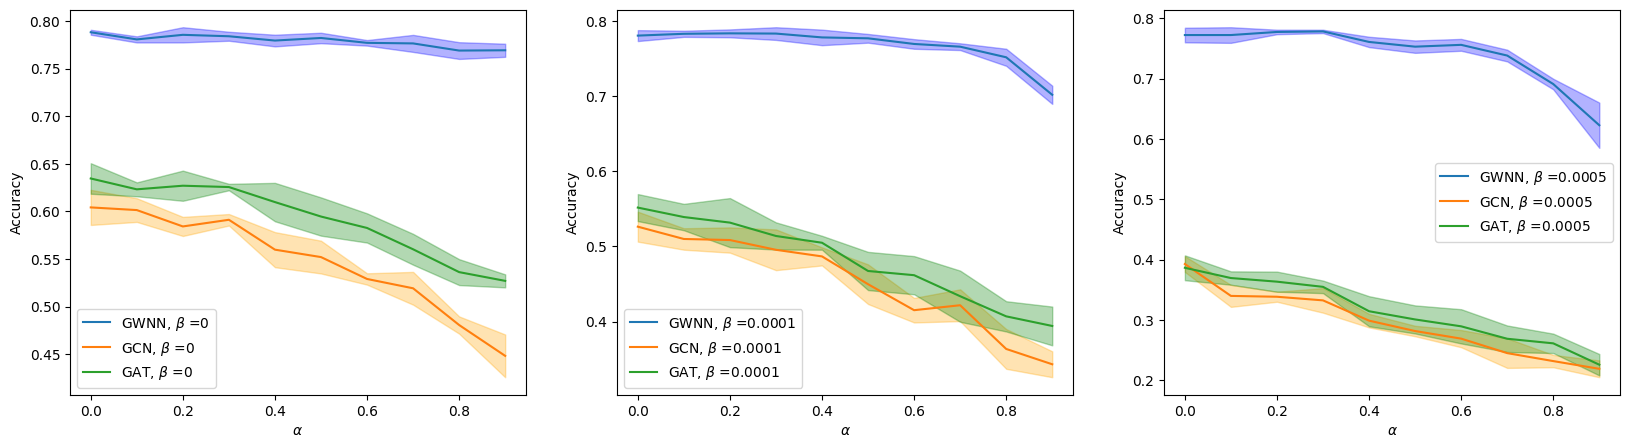

In [ ]:
fig,ax = plt.subplots(1,3,figsize = (20,5))

for j,beta in enumerate(betas) :
    i=j
    ax[i].plot(alphas, wave_means[j], label = r'GWNN, $\beta$ ='+ str(beta))
    propreax(ax[i], alphas, wave_means[j], wave_stds[j], 'blue')
    ax[i].plot(alphas, gcn_means[j], label = r'GCN, $\beta$ ='+ str(beta))
    propreax(ax[i], alphas, gcn_means[j], gcn_stds[j], 'orange')
    ax[i].plot(alphas, gat_means[j], label = r'GAT, $\beta$ ='+ str(beta))
    propreax(ax[i], alphas, gat_means[j], gat_stds[j], 'green')
    ax[i].set_ylabel('Accuracy')
    ax[i].set_xlabel(r'$\alpha$')
    ax[i].legend()
fig.show()


# Analyze node degrees

3
[  0   0   0 485 583 553 389 281 131  82  57  25  26  14  18   5   6   6
   7   8]
[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5
 13.5 14.5 15.5 16.5 17.5 18.5 19.5]
Input Graph : Graph with 2708 nodes and 7986 edges
Removing 798 edges.
Adding 0 edges.
Output Graph : Graph with 2708 nodes and 7188 edges
0
[  7  54 107 547 603 533 331 213  98  56  36  25  22   7  12   9   7   8
   5   3]
[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5
 13.5 14.5 15.5 16.5 17.5 18.5 19.5]
Input Graph : Graph with 2708 nodes and 7986 edges
Removing 1597 edges.
Adding 0 edges.
Output Graph : Graph with 2708 nodes and 6389 edges
0
[ 33 119 236 607 579 467 273 147  73  60  28  18   7  11   7   5  11   2
   3   2]
[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5
 13.5 14.5 15.5 16.5 17.5 18.5 19.5]


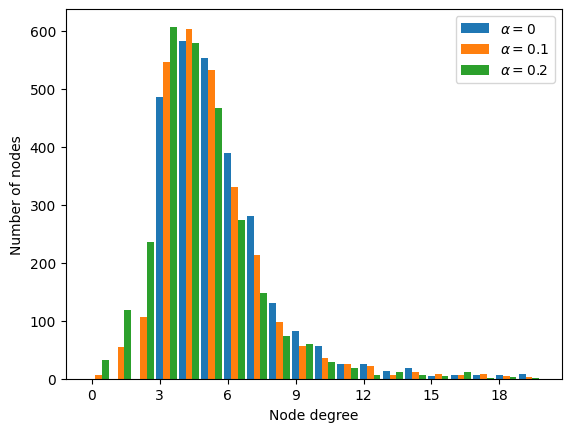

In [ ]:
from matplotlib.ticker import MaxNLocator
# Get list of degrees for each node
def plot_deg(ax, g, m, label, deca= 0):
    degrees = g.degree #degree(g.edge_index[0]).numpy()

# Count the number of nodes for each degree

# Bar plot

    # plt.bar(numbers.keys(),
    #         numbers.values(),
    #         color='#0A047A')
    ok = list(map(lambda x : x[1], degrees))
    print(min(ok))
    counts, bins = np.histogram(ok, bins = m, range = (-.5,m-.5))
    print(counts)
    print(bins)
    
    ax.bar(np.array(list(range(m))) + np.array([deca]*m), counts, width = .3, alpha = 1, label = label)
fig,ax = plt.subplots(1)
plot_deg(ax,G, 20, label = r'$\alpha = 0$')
plot_deg(ax,noise_edges(G,.1,0), 20, label = r'$\alpha = 0.1$', deca = .3)
plot_deg(ax,noise_edges(G,.2,0), 20, label = r'$\alpha = 0.2$', deca = .6)

# plot_deg(ax,G, 20)

ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.legend()
fig.show()
fig.savefig('/content/drive/MyDrive/GeometricDeepLearning/degrees1.jpg')
# pyplot.hist(x, bins, alpha=0.5, label='x')
# pyplot.hist(y, bins, alpha=0.5, label='y')
# pyplot.legend(loc='upper right')
# pyplot.show()